# Problem set 3
## "The adventure of the missing phenotype"
### Zachary Miller

## Part 1: Testing Moriarty's method
__test moriartyies method__

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

def moriarty_score(sequence):
    score = 0
    for i in sequence:
        if i == "A" or i == "T":
            score += 1
            
        elif i == "G" or i=="C":
            score -= 1
            
    return score

def get_seqs_from_fasta(fasta_file):
    seq_list = []
    file = open(fasta_file, "r")
    lines = file.readlines()
    lines = [i.rstrip("\n") for i in lines]
    last_line = lines[-1] 
    
    # Iterate over each line and add all the sequence lines for a given transcript to one string, then append that 
    # string to the sequence list
    s = ""
    for line in lines:
        if line[0] == ">":
            if len(s) == 0: continue
                
            else: 
                seq_list.append(s)
                s = ""
                
        elif line is last_line:
            seq_list.append(s)
            
        else:
            s = s+line
            
    file.close() 
    return seq_list
    
def tt_data_split(data, split):
    """Given a list of data and a number between 0 and 1, splits the data into testing and training data according
    to the portion given by split, where the number split gives the portion of training data"""
    
    split_num = int(round(len(data)*split))
    random.shuffle(data) # shuffle the data to ensure randomness
    
    train_data = data[:split_num-1]
    test_data = data[split_num:]
    
    return train_data, test_data
        
    

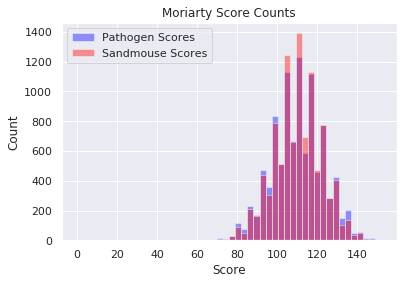

In [2]:
# Read in the sequences
path_seq_list = get_seqs_from_fasta("pathogen.fa")
sm_seq_list = get_seqs_from_fasta("sandmouse.fa")

# Get the scores using Moriarty's method for both sequences
moriarty_path_scores = []
moriarty_sm_scores = []

for seq in path_seq_list:
    moriarty_path_scores.append(moriarty_score(seq))
    
for seq in sm_seq_list:
    moriarty_sm_scores.append(moriarty_score(seq))

# Plot the scores histograms
plt.figure("Score Counts")
sns.set()
ax1 = sns.distplot(moriarty_path_scores, kde=False, color="blue", label="Pathogen Scores")
ax1 = sns.distplot(moriarty_sm_scores, kde=False, color="red", label="Sandmouse Scores")
ax1.set_title("Moriarty Score Counts")
ax1.set_xlabel("Score")
ax1.set_ylabel("Count")
plt.legend()
plt.show()

We are now asked to impliment a second order Markov model which we will use to classify a given sequence as being from the mouse or from the pathogen. In a second order Markov model, we assume that each letter in the sequence is dependent on the two preceeding letters, and therefore $P(x_i|x_{i-1},x_{i-2})$. Since the first two nucleotides of our sequence do not have two proceeding nucleotides, we will assume that their probabilities are conditionally independent, but not unconditionally independent from eachother, and are therefore given by $P(x_1,x_2)$. Assuming that the probability of any given nucelotide is not dependent on the position of that nucleotide (except for the first two), we now have an expression for the likelyhood of any given sequence of length $L$: $$P(x_1,...,x_L)=P(x_1,x_2)\prod_{i=3}^{L}P(x_i|x_{i-1},x_{i-2})$$ Where $x_i$ is the ith nucelotide in the sequence. 

In order to impliment this model, we will first have to estimate all the relevant probabilities. To do so, we will use the maximum likelyhood estimate $\hat{p}$ for the following set up. __Basically I just want to show that we can set up the counts of substrings within a main string as a binomial distribuition of successes in a number of trials, and then it can be shown that the MLE of the success probability is the portion of successes__ In order to obtain these counts, we need to split our labled sequences into testing and training data...

In [36]:
# Split the labeled sequences into testing and training data
path_train_seq_list, path_test_seq_list = tt_data_split(path_seq_list, 0.5)
sm_train_seq_list, sm_test_seq_list = tt_data_split(sm_seq_list, 0.5)

def create_occurence_lists(seq_list):
    """ Given a list of sequences, return an occurence list for each nucleotide letter. Each occurance list should
    be a list of n 3 character strings, where each 3 character string ends in the nucleotide letter the list 
    cooresponds to and includes the two preceding letters in the seqeunce. Note that this function is not for general
    use"""
    nuc_list = ["A", "G", "T", "C"]
    A_occ_list = []
    G_occ_list = []
    T_occ_list = []
    C_occ_list = []

    # Iterate over each possible nucleotide letter
    for letter in nuc_list:
        temp_occ_list = []
        # Iterate over each sequence in the training sequences
        for seq in seq_list:
            # Iterate over each character in the sequence (starting at the 3rd character)
            for idx, c in enumerate(seq[2:]):
                # If the character matches the current nucleotide letter, add it and it's two preceding characters to
                # the temporary occurence list
                if c == letter:
                    temp_occ_list.append(seq[idx:idx+3])

        # Assign the proper nucleotide occurance list to the temporary occurance list
        if letter == "A": A_occ_list = temp_occ_list
        if letter == "G": G_occ_list = temp_occ_list
        if letter == "T": T_occ_list = temp_occ_list
        if letter == "C": C_occ_list = temp_occ_list

    return A_occ_list, G_occ_list, T_occ_list, C_occ_list

# Create lists for each occurence of A, G, T, or C, along with the two proceeding letters
A_path_occ_list, G_path_occ_list, T_path_occ_list, C_path_occ_list = create_occurence_lists(path_train_seq_list)
A_sm_occ_list, G_sm_occ_list, T_sm_occ_list, C_sm_occ_list = create_occurence_lists(sm_train_seq_list)

# Next step would be to get the the counts of each unique sequence, divide by the total count to get the probability,
# and then add them to an dict for easy reference later...

In [39]:
C_sm_occ_list

['TAC',
 'GTC',
 'TAC',
 'TAC',
 'ATC',
 'GTC',
 'AAC',
 'AGC',
 'GTC',
 'TCC',
 'TTC',
 'ATC',
 'AGC',
 'GCC',
 'TAC',
 'AAC',
 'TAC',
 'AAC',
 'CAC',
 'CTC',
 'TTC',
 'AGC',
 'TTC',
 'AAC',
 'TTC',
 'GGC',
 'ATC',
 'TGC',
 'AAC',
 'TTC',
 'TTC',
 'AAC',
 'AGC',
 'TTC',
 'TGC',
 'GGC',
 'CAC',
 'AAC',
 'TAC',
 'ACC',
 'TTC',
 'AAC',
 'GAC',
 'AGC',
 'TAC',
 'AGC',
 'AAC',
 'TTC',
 'CAC',
 'TTC',
 'TTC',
 'TCC',
 'AAC',
 'AGC',
 'TGC',
 'GTC',
 'TCC',
 'ATC',
 'TTC',
 'AGC',
 'GCC',
 'TTC',
 'TTC',
 'TAC',
 'ACC',
 'ATC',
 'TTC',
 'TAC',
 'TAC',
 'TAC',
 'TTC',
 'GTC',
 'TGC',
 'AAC',
 'ATC',
 'AGC',
 'TTC',
 'AAC',
 'ATC',
 'TAC',
 'GGC',
 'ATC',
 'TCC',
 'CCC',
 'CTC',
 'ATC',
 'TCC',
 'TAC',
 'AAC',
 'AAC',
 'AAC',
 'GGC',
 'TTC',
 'AGC',
 'TAC',
 'AGC',
 'GGC',
 'TAC',
 'AGC',
 'ATC',
 'CTC',
 'TTC',
 'TCC',
 'TTC',
 'TCC',
 'TAC',
 'AGC',
 'GTC',
 'ATC',
 'TTC',
 'ATC',
 'AAC',
 'ACC',
 'TAC',
 'TTC',
 'TTC',
 'ATC',
 'TGC',
 'AGC',
 'AGC',
 'CGC',
 'AGC',
 'GGC',
 'TAC',
 'AGC',
